# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from collections import Counter

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
#path = '/content/drive/My Drive/Copy of preprocessed_data.csv'
trainpath = '/content/drive/My Drive/Copy of train_data.csv'

data_train = pd.read_csv(trainpath)

In [0]:
path = '/content/drive/My Drive/Copy of resources.csv'
data_resource = pd.read_csv(path)

In [5]:
data_resource.head(1)


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.0


In [6]:
data_train.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0


In [7]:
print(data_resource.columns)
print("=" * 70)
print("Shape of the data: " , data_resource.shape)
print("=" * 70)
print(data_resource.isna().sum())
print("=" * 70)
print(data_resource.dtypes)
print("=" * 70)
print(data_train.columns)
print("=" * 70)
print("Shape of the data: " , data_train.shape)
print("=" * 70)
print(data_train.isna().sum())
print("=" * 70)
print(data_train.dtypes)

Index(['id', 'description', 'quantity', 'price'], dtype='object')
Shape of the data:  (1541272, 4)
id               0
description    292
quantity         0
price            0
dtype: int64
id              object
description     object
quantity         int64
price          float64
dtype: object
Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')
Shape of the data:  (109248, 17)
Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       3
school_st

**Preprocessing of data**



1. project_subject_categories

In [0]:
catogories = list(data_train['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
data_train['clean_categories'] = cat_list
data_train.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in data_train['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

2. project_subject_subcategories

In [0]:
catogories = list(data_train['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
data_train['clean_categories'] = cat_list
data_train.drop(['project_subject_subcategories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in data_train['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

3. project_grade_category

In [10]:
data_train['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

Observation: So it is clear that for which class the amount of projects are targetted.Most is for "Grades PreK-2" 

In [11]:
preprocessed_project_grade_categories= []

for grade_cat in tqdm(data_train["project_grade_category"]):
   
    grade_cat = grade_cat.replace('-', '_')  #Replacing(-) with(_)
    grade_cat = grade_cat.replace('Grades', '') #Removing grades as it is redundant
    #grade_cat = grade_cat.replace('PreK', '0')

    grad_cat = ' '.join(f for f in grade_cat.split())
    preprocessed_project_grade_categories.append(grad_cat.strip())

100%|██████████| 109248/109248 [00:00<00:00, 550421.54it/s]


In [12]:
print(preprocessed_project_grade_categories[1])
print("="*50)
print(preprocessed_project_grade_categories[50])
print("="*50)
print(preprocessed_project_grade_categories[500])
print("="*50)
print(preprocessed_project_grade_categories[5000])
print("="*50)
print(preprocessed_project_grade_categories[10001])
print("="*50)

6_8
PreK_2
9_12
PreK_2
PreK_2


4. teacher_prefix                                  

In [13]:
data_train['teacher_prefix'].isna().sum()



3

In [0]:
data_train['teacher_prefix'] = data_train['teacher_prefix'].fillna('null')

In [0]:
def replace_cate(lst):          # Removing (.) in Mrs. 
    return lst.replace('.','')
   

data_train['teacher_prefix']= data_train['teacher_prefix'].astype(str).apply(replace_cate)

In [16]:
print(data_train['teacher_prefix'])

0         Mrs
1          Mr
2          Ms
3         Mrs
4         Mrs
         ... 
109243     Mr
109244     Ms
109245    Mrs
109246    Mrs
109247     Ms
Name: teacher_prefix, Length: 109248, dtype: object


In [17]:
preprocessed_teacher_prefix = []

for teach_prefix in tqdm(data_train["teacher_prefix"]):
    
    preprocessed_teacher_prefix.append(teach_prefix.strip())

100%|██████████| 109248/109248 [00:00<00:00, 1733125.52it/s]


In [18]:
data_train['teacher_prefix'].value_counts()

Mrs        57269
Ms         38955
Mr         10648
Teacher     2360
Dr            13
null           3
Name: teacher_prefix, dtype: int64

5. Adding a new feature Number of words in title

In [0]:
title_word_count = []

for a in data_train["project_title"] :
    b = len(a.split())
    title_word_count.append(b)

data_train["title_word_count"] = title_word_count    

In [20]:
data_train['title_word_count']

0         7
1         5
2         7
3         2
4         3
         ..
109243    6
109244    4
109245    6
109246    5
109247    7
Name: title_word_count, Length: 109248, dtype: int64

# merge 4 column text dataframe: 

In [0]:
# https://towardsdatascience.com/natural-language-processing-on-multiple-columns-in-python-554043e05308
data_train["essay"] = data_train["project_essay_1"].map(str) +\
                        data_train["project_essay_2"].map(str) + \
                        data_train["project_essay_3"].map(str) + \
                        data_train["project_essay_4"].map(str)

In [0]:
essay_word_count=[]
for ess in data_train["essay"] :
    c = len(ess.split())
    essay_word_count.append(c)

data_train["essay_word_count"] = essay_word_count    

In [23]:
data_train.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,title_word_count,essay,essay_word_count
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,ESL Literacy,7,My students are English learners that are work...,272


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_train, data_train['project_is_approved'], test_size=0.33, stratify = data_train['project_is_approved'],random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train,random_state=0)    

In [0]:
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
X_cv.drop(['project_is_approved'], axis=1, inplace=True)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent = decontracted(X_train['essay'].values[40000])



In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: no,not,nor
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [29]:
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentence in tqdm(X_train['essay'].values):
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)

    preprocessed_essays_train.append(sent.lower().strip())

100%|██████████| 49041/49041 [00:27<00:00, 1780.95it/s]


In [30]:
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentence in tqdm(X_test['essay'].values):
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    
    preprocessed_essays_test.append(sent.lower().strip())

100%|██████████| 36052/36052 [00:20<00:00, 1776.15it/s]


In [31]:
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentence in tqdm(X_cv['essay'].values):
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    
    preprocessed_essays_cv.append(sent.lower().strip())

100%|██████████| 24155/24155 [00:13<00:00, 1777.39it/s]


6. project_title

In [0]:
title = decontracted(X_train['project_title'].values[40000])

In [33]:
preprocessed_titles_train = []

for titles in tqdm(X_train["project_title"]):
    title = ' '.join(f for f in title.split() if f not in stopwords)
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    
    preprocessed_titles_train.append(title.lower().strip())

100%|██████████| 49041/49041 [00:01<00:00, 40554.24it/s]


In [34]:
preprocessed_titles_test = []

for titles in tqdm(X_test["project_title"]):
    title = ' '.join(f for f in title.split() if f not in stopwords)
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    
    preprocessed_titles_test.append(title.lower().strip())

100%|██████████| 36052/36052 [00:00<00:00, 41350.04it/s]


In [35]:
preprocessed_titles_cv = []

for titles in tqdm(X_cv["project_title"]):
    title = ' '.join(f for f in title.split() if f not in stopwords)
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    
    preprocessed_titles_cv.append(title.lower().strip())

100%|██████████| 24155/24155 [00:00<00:00, 40797.76it/s]


In [36]:
print("train project:", preprocessed_titles_train[20] )
print("test project:", preprocessed_titles_test[20] )
print("cv project:", preprocessed_titles_cv[20] )

train project: calling all questions
test project: furniture for first grade
cv project: movement motivates learning sight words and vocabulary words


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label



In [38]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'title_word_count', 'essay', 'essay_word_count'],
      dtype='object')

a. vectorize - categorical data

clean_categories

In [39]:
print(X_train['clean_categories'])

75742                               VisualArts
61001                         ForeignLanguages
86123                              Mathematics
13405                                 Literacy
71845           AppliedSciences PerformingArts
                         ...                  
7607                           AppliedSciences
60234                             SpecialNeeds
65837              CharacterEducation Literacy
22568    CharacterEducation College_CareerPrep
7728            Literature_Writing Mathematics
Name: clean_categories, Length: 49041, dtype: object


In [40]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_train = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_train.fit(X_train['clean_categories'].values)

categories_vect_train = vectorizer_train.transform(X_train['clean_categories'].values)
categories_vect_test = vectorizer_train.transform(X_test['clean_categories'].values)
categories_vect_cv = vectorizer_train.transform(X_cv['clean_categories'].values)

print(vectorizer_train.get_feature_names())

print("Shape of Train data after vectorization: ",categories_vect_train.shape)
print("Shape of Test data after vectorization: ",categories_vect_test.shape)
print("Shape of CV data after vectorization: ",categories_vect_cv.shape)
	

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of Train data after vectorization:  (49041, 30)
Shape of Test data after vectorization:  (36052, 30)
Shape of CV data after vectorization:  (24155, 30)


school_state

In [0]:
my_counter = Counter()
for state in data_train['school_state'].values:
    my_counter.update(state.split())

school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))    

In [42]:
vectorizer_states = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_states.fit(X_train['school_state'].values)

school_state_categories_vect_train = vectorizer_states.transform(X_train['school_state'].values)
school_state_categories_vect_test = vectorizer_states.transform(X_test['school_state'].values)
school_state_categories_vect_cv = vectorizer_states.transform(X_cv['school_state'].values)

print(vectorizer_states.get_feature_names())

print("Shape of Train data after vectorization: ",school_state_categories_vect_train.shape)
print("Shape of test data after vectorization: ",school_state_categories_vect_test.shape)
print("Shape of cross Validation data after vectorization: ",school_state_categories_vect_cv.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of Train data after vectorization:  (49041, 51)
Shape of test data after vectorization:  (36052, 51)
Shape of cross Validation data after vectorization:  (24155, 51)


project_grade_category

In [0]:
my_counter = Counter()
for state in data_train['project_grade_category'].values:
    my_counter.update(state.split())

project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))   

In [44]:
vectorizer_project = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_project.fit(X_train['project_grade_category'].values)

project_grade_categories_vect_train = vectorizer_project.transform(X_train['project_grade_category'].values)
project_grade_categories_vect_test = vectorizer_project.transform(X_test['project_grade_category'].values)
project_grade_categories_vect_cv = vectorizer_project.transform(X_cv['project_grade_category'].values)

print(vectorizer_project.get_feature_names())

print("Shape of Train data after vectorization: ",project_grade_categories_vect_train.shape)
print("Shape of test data after vectorization: ",project_grade_categories_vect_test.shape)
print("Shape of cross Validation data after vectorization: ",project_grade_categories_vect_cv.shape)

['9-12', '6-8', '3-5', 'PreK-2', 'Grades']
Shape of Train data after vectorization:  (49041, 5)
Shape of test data after vectorization:  (36052, 5)
Shape of cross Validation data after vectorization:  (24155, 5)


teacher

In [45]:
vectorizer_teacher = CountVectorizer()
vectorizer_teacher.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
teacher_prefix_categories_vect_train = vectorizer_teacher.transform(X_train['teacher_prefix'].values)
teacher_prefix_categories_vect_cv = vectorizer_teacher.transform(X_cv['teacher_prefix'].values)
teacher_prefix_categories_vect_test = vectorizer_teacher.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print("Shape of Train data ",teacher_prefix_categories_vect_train.shape, y_train.shape)
print("Shape of cv data ",teacher_prefix_categories_vect_cv.shape, y_cv.shape)
print("Shape of test data",teacher_prefix_categories_vect_test.shape, y_test.shape)
print(vectorizer_teacher.get_feature_names())

After vectorizations
Shape of Train data  (49041, 6) (49041,)
Shape of cv data  (24155, 6) (24155,)
Shape of test data (36052, 6) (36052,)
['dr', 'mr', 'mrs', 'ms', 'null', 'teacher']


1. Bag of words

In [46]:
##For train
vectorizer_bow_essay = CountVectorizer(min_df=10,max_features=50000)  #selecting top 50000 features
vectorizer_bow_essay.fit(preprocessed_essays_train)

text_bow_train = vectorizer_bow_essay.transform(preprocessed_essays_train)

print("Shape of matrix after one hot encoding ",text_bow_train.shape)

Shape of matrix after one hot encoding  (49041, 12184)


In [47]:
##For Test
text_bow_test = vectorizer_bow_essay.transform(preprocessed_essays_test)
print("Shape of matrix after one hot encoding ",text_bow_test.shape)

Shape of matrix after one hot encoding  (36052, 12184)


In [48]:
##For CV
text_bow_cv = vectorizer_bow_essay.transform(preprocessed_essays_cv)
print("Shape of matrix after one hot encoding ",text_bow_cv.shape)

Shape of matrix after one hot encoding  (24155, 12184)


In [49]:
##For train titles

vectorizer_bow_title = CountVectorizer(min_df=10)
vectorizer_bow_title.fit(preprocessed_titles_train)
title_bow_train = vectorizer_bow_title.transform(preprocessed_titles_train)
print("Shape of matrix after one hot encoding ",title_bow_train.shape)

Shape of matrix after one hot encoding  (49041, 2105)


In [50]:
##For test titles

title_bow_test = vectorizer_bow_title.transform(preprocessed_titles_test)
print("Shape of matrix after one hot encoding ",title_bow_test.shape)

Shape of matrix after one hot encoding  (36052, 2105)


In [51]:
##For CV titles

title_bow_cv = vectorizer_bow_title.transform(preprocessed_titles_cv)
print("Shape of matrix after one hot encoding ",title_bow_cv.shape)

Shape of matrix after one hot encoding  (24155, 2105)


2. TFIDF

In [52]:
##For train essay
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf_essay = TfidfVectorizer(min_df=10,max_features=50000) #Considering top 50000 features
vectorizer_tfidf_essay.fit(preprocessed_essays_train)

text_tfidf_train = vectorizer_tfidf_essay.transform(preprocessed_essays_train)
print("Shape of matrix after one hot encoding ",text_tfidf_train.shape)

Shape of matrix after one hot encoding  (49041, 12184)


In [53]:
##For test essay
text_tfidf_test = vectorizer_tfidf_essay.transform(preprocessed_essays_test)
print("Shape of matrix after one hot encoding ",text_tfidf_test.shape)

Shape of matrix after one hot encoding  (36052, 12184)


In [54]:
##For cv essay
text_tfidf_cv = vectorizer_tfidf_essay.transform(preprocessed_essays_cv)
print("Shape of matrix after one hot encoding ",text_tfidf_cv.shape)

Shape of matrix after one hot encoding  (24155, 12184)


In [55]:
##For train titles

vectorizer_tfidf_titles = TfidfVectorizer(min_df=10)

vectorizer_tfidf_titles.fit(preprocessed_titles_train) 
title_tfidf_train = vectorizer_tfidf_titles.transform(preprocessed_titles_train) 
print("Shape of matrix after one hot encoding ",title_tfidf_train.shape)

Shape of matrix after one hot encoding  (49041, 2105)


In [56]:
##For test titles
title_tfidf_test = vectorizer_tfidf_titles.transform(preprocessed_titles_test)
print("Shape of matrix after one hot encoding ",title_tfidf_test.shape)

Shape of matrix after one hot encoding  (36052, 2105)


In [57]:
##For cv titles
title_tfidf_cv = vectorizer_tfidf_titles.transform(preprocessed_titles_cv)
print("Shape of matrix after one hot encoding ",title_tfidf_cv.shape)

Shape of matrix after one hot encoding  (24155, 2105)


**NUMERICAL FEATURES**

1. price

In [58]:
price_data = data_resource.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()


data_resource.columns
data_resource.dtypes
print(X_train.columns)
print(price_data.head(1))

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'title_word_count', 'essay', 'essay_word_count'],
      dtype='object')
        id   price  quantity
0  p000001  459.56         7


In [0]:
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')
X_cv = pd.merge(X_cv, price_data, on='id', how='left')

In [60]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(1,-1))

price_train = normalizer.transform(X_train['price'].values.reshape(1,-1))
price_cv = normalizer.transform(X_cv['price'].values.reshape(1,-1))
price_test = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(price_train.shape, y_train.shape)
print(price_cv.shape, y_cv.shape)
print(price_test.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


quantity

In [61]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['quantity'].values.reshape(1,-1))

quantity_train = normalizer.transform(X_train['quantity'].values.reshape(1,-1))
quantity_cv = normalizer.transform(X_cv['quantity'].values.reshape(1,-1))
quantity_test = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

print("After vectorizations")
print(quantity_train.shape, y_train.shape)
print(quantity_cv.shape, y_cv.shape)
print(quantity_test.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


teacher_number_of_previously_posted_projects

In [62]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

prev_projects_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_cv = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(prev_projects_train.shape, y_train.shape)
print(prev_projects_cv.shape, y_cv.shape)
print(prev_projects_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


title_word_count

In [63]:
normalizer = Normalizer()

normalizer.fit(X_train['title_word_count'].values.reshape(1,-1))

title_word_count_train = normalizer.transform(X_train['title_word_count'].values.reshape(1,-1))
title_word_count_cv = normalizer.transform(X_cv['title_word_count'].values.reshape(1,-1))
title_word_count_test = normalizer.transform(X_test['title_word_count'].values.reshape(1,-1))

print("After vectorizations")
print(title_word_count_train.shape, y_train.shape)
print(title_word_count_cv.shape, y_cv.shape)
print(title_word_count_test.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


essay_word_count

In [64]:
normalizer = Normalizer()

normalizer.fit(X_train['essay_word_count'].values.reshape(1,-1))

essay_word_count_train = normalizer.transform(X_train['essay_word_count'].values.reshape(1,-1))
essay_word_count_cv = normalizer.transform(X_cv['essay_word_count'].values.reshape(1,-1))
essay_word_count_test = normalizer.transform(X_test['essay_word_count'].values.reshape(1,-1))

print("After vectorizations")
print(essay_word_count_train.shape, y_train.shape)
print(essay_word_count_cv.shape, y_cv.shape)
print(essay_word_count_test.shape, y_test.shape)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [0]:
price_train = (X_train['price'].values.reshape(-1,1))
price_cv = (X_cv['price'].values.reshape(-1,1))
price_test = (X_test['price'].values.reshape(-1,1))

quantity_train =(X_train['quantity'].values.reshape(-1,1))
quantity_cv = (X_cv['quantity'].values.reshape(-1,1))
quantity_test = (X_test['quantity'].values.reshape(-1,1))

prev_projects_train = (X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_cv = (X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = (X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

title_word_count_train = (X_train['title_word_count'].values.reshape(-1,1))
title_word_count_cv = (X_cv['title_word_count'].values.reshape(-1,1))
title_word_count_test = (X_test['title_word_count'].values.reshape(-1,1))


essay_word_count_train = (X_train['essay_word_count'].values.reshape(-1,1))
essay_word_count_cv = (X_cv['essay_word_count'].values.reshape(-1,1))
essay_word_count_test = (X_test['essay_word_count'].values.reshape(-1,1))


In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_final = hstack((categories_vect_train, school_state_categories_vect_train, project_grade_categories_vect_train, teacher_prefix_categories_vect_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, title_bow_train, text_bow_train)).tocsr()
X_test_final = hstack((categories_vect_test,  school_state_categories_vect_test, project_grade_categories_vect_test, teacher_prefix_categories_vect_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, title_bow_test, text_bow_test)).tocsr()
X_cr_final = hstack((categories_vect_cv,  school_state_categories_vect_cv, project_grade_categories_vect_cv, teacher_prefix_categories_vect_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, title_bow_cv, text_bow_cv)).tocsr()



In [67]:
print("Final Data shapes")
print(X_train_final.shape, y_train.shape)
print(X_cr_final.shape, y_cv.shape)
print(X_test_final.shape, y_test.shape)
print("="*100)

print(type(X_train_final))
print(type(y_train))

Final Data shapes
(49041, 14386) (49041,)
(24155, 14386) (24155,)
(36052, 14386) (36052,)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.series.Series'>


In [0]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

**GRID SEARCH**

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(class_prior=[0.5,0.5])

parameters = {'alpha':[0.00001, 0.0001,0.001, 0.01, 0.1,0.5,0.8, 1, 10,  100,  1000]}

clf = GridSearchCV(nb, parameters, cv= 10, scoring='roc_auc',return_train_score=True,verbose=2)

clf.fit(X_train_final, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

Fitting 10 folds for each of 11 candidates, totalling 110 fits
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:   13.8s finished


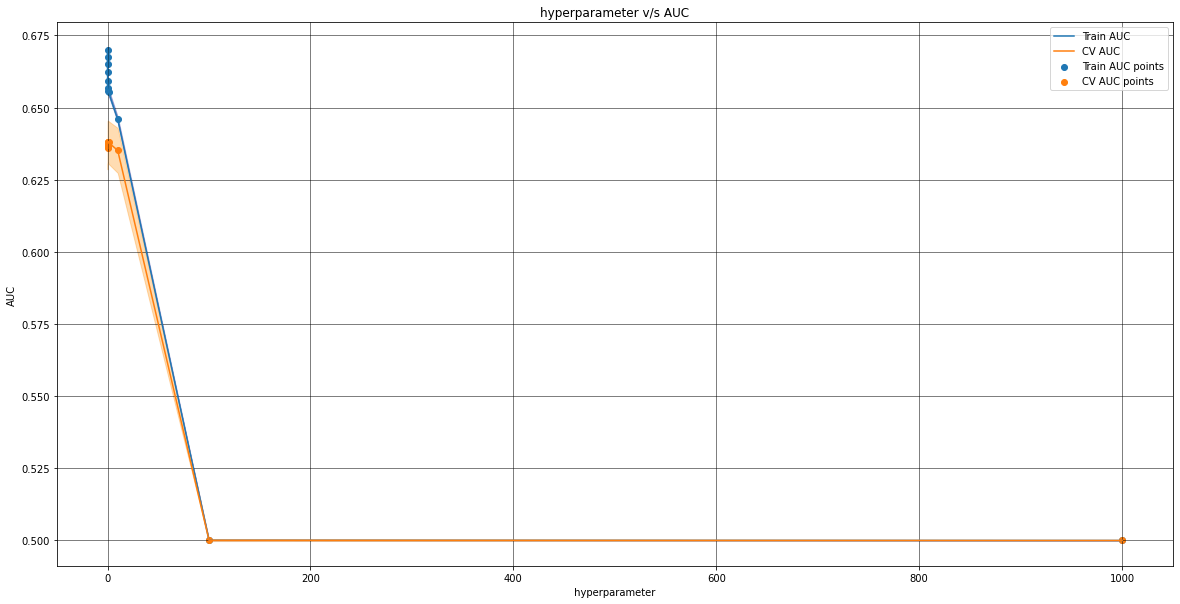

In [70]:
import math
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1,0.5,0.8, 1, 10,  100,  1000]
log_alphas =[]



plt.figure(figsize=(20,10))

plt.plot(alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel(" hyperparameter ")
plt.ylabel("AUC")
plt.title("hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

100%|██████████| 11/11 [00:00<00:00, 17765.63it/s]


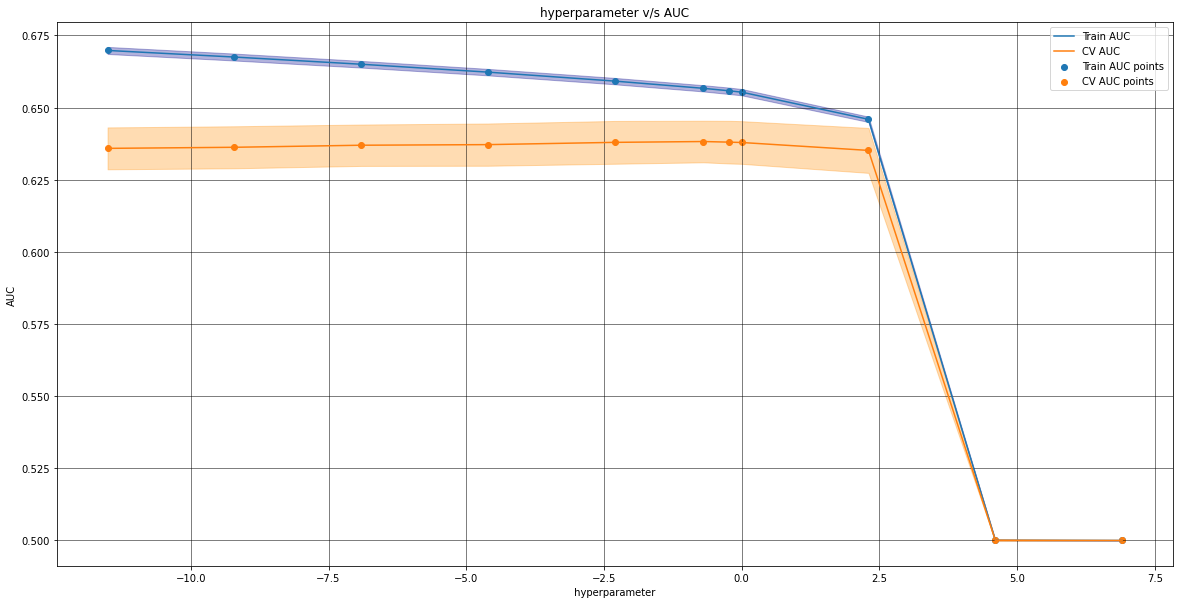

In [71]:
import math
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1,0.5,0.8, 1, 10,  100,  1000]
log_alphas =[]

for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

plt.figure(figsize=(20,10))

plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel(" hyperparameter ")
plt.ylabel("AUC")
plt.title("hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [72]:
best_param = clf.best_params_  ## https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch
print(best_param)

{'alpha': 0.5}


<h1>3. **Summary**</h1>

1. As it is clear that just using hyperparameters as it is gives a non interpretable graph. Whereas log values of it gives a better understanding of how the AUC is varying with hyperparameters.
2. Here we have taken the hyperparameter ranging from 0.00001 to 1000.
3. From the graph it can be seen that as value of alpha increases train AUC and cv AUC starts to converge.
4. by using best_params_ function we were able to get the best hyperparameter value.

**Training Model using the best hyperparameter**

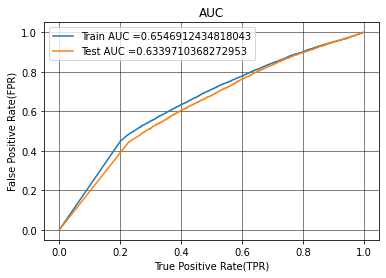

In [73]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

nb_bow = MultinomialNB(0.5,class_prior=[0.5,0.5])

nb_bow.fit(X_train_final, y_train)

y_train_pred = batch_predict(nb_bow, X_train_final)    
y_test_pred = batch_predict(nb_bow, X_test_final)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

**Summary**

1. By using auc module under sklearn we are able to find auc scores easily.
2. Used the best alpha value 0.5 to train the model which gave auc score of train and test data as shown in the graph. i.e. 0.6546 and 0.6339 repectively.

**Getting confusion matrix of train and test data**

In [0]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [75]:
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train data confusion matrix
[[ 3714  3712]
 [12044 29571]]


In [76]:

print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
[[ 3066  2393]
 [11212 19381]]


**Top 20 features** 

In [0]:
bow_features_names1 = []
for cnt in vectorizer_train.get_feature_names() :
    bow_features_names1.append(cnt)

for cnt2 in vectorizer_states.get_feature_names() :
    bow_features_names1.append(cnt2)

for cnt3 in vectorizer_project.get_feature_names() :
    bow_features_names1.append(cnt3)

for cnt4 in vectorizer_teacher.get_feature_names() :
    bow_features_names1.append(cnt4)

for cnt5 in vectorizer_bow_title.get_feature_names() :
    bow_features_names1.append(cnt5)

for cnt6 in vectorizer_bow_essay.get_feature_names() :
    bow_features_names1.append(cnt6)        

In [78]:

bow_features_names1.append("price")

bow_features_names1.append("quantity")


bow_features_names1.append("prev_proposed_projects")

bow_features_names1.append("title_word_count")

bow_features_names1.append("essay_word_count")

len(bow_features_names1)

14386

In [79]:
sorted_features = nb_bow.feature_log_prob_[1, :].argsort()[::-1]
for i in sorted_features[:20]:
    print(bow_features_names1[i])


04
123
05
10
toe
angeles
their
studnets
offering
101
inadequate
myself
arguably
thing
themed
willing
islanders
ford
outcome
hawaii


**TFIDF data set**

In [0]:
X_Train_final = hstack((categories_vect_train, project_grade_categories_vect_train, teacher_prefix_categories_vect_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, title_tfidf_train, text_tfidf_train)).tocsr()
X_Test_final = hstack((categories_vect_test, project_grade_categories_vect_test, teacher_prefix_categories_vect_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, title_tfidf_test, text_tfidf_test)).tocsr()
X_CV_final = hstack((categories_vect_cv, project_grade_categories_vect_cv, teacher_prefix_categories_vect_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, title_tfidf_cv, text_tfidf_cv)).tocsr()

In [84]:
print("Final data shape")
print(X_Train_final.shape, y_train.shape)
print(X_CV_final.shape, y_cv.shape)
print(X_Test_final.shape, y_test.shape)
print("=" * 70)

Final data shape
(49041, 14335) (49041,)
(24155, 14335) (24155,)
(36052, 14335) (36052,)


In [85]:
nb = MultinomialNB(class_prior=[0.5,0.5])

parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1,0.25,0.5,0.8, 1,100]}

clf = GridSearchCV(nb, parameters, cv= 10, scoring='roc_auc',return_train_score=True,verbose=2)

clf.fit(X_Train_final, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.5s finished


100%|██████████| 10/10 [00:00<00:00, 23392.66it/s]


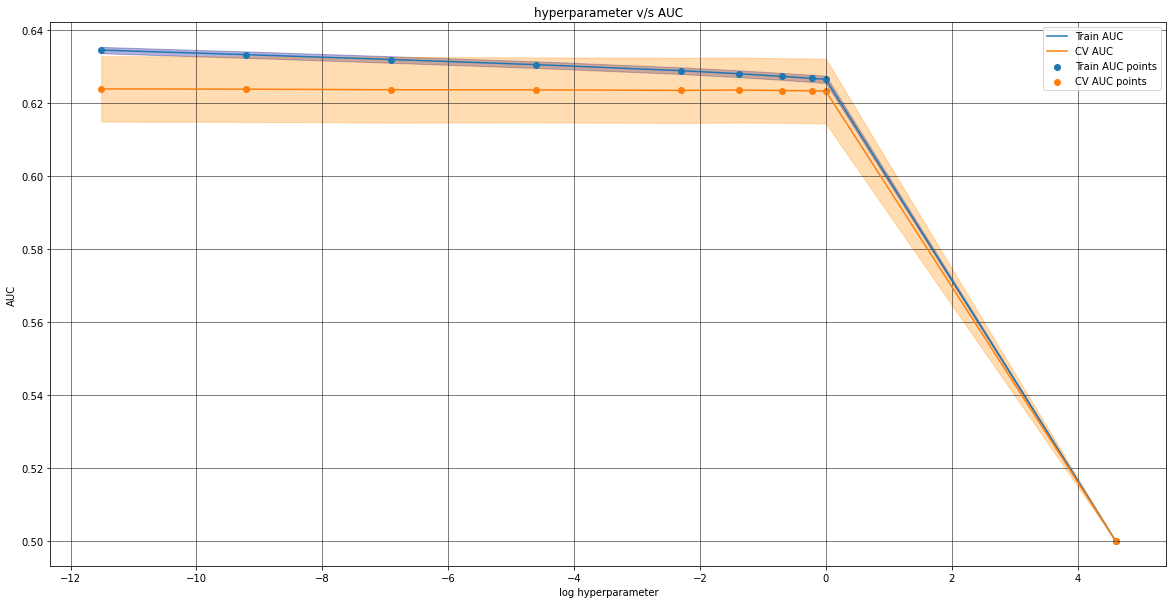

In [87]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1,0.25,0.5,0.8, 1,100]
log_alphas =[]

for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

plt.figure(figsize=(20,10))

plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log hyperparameter")
plt.ylabel("AUC")
plt.title("hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [91]:
best_param1 = clf.best_params_
print(best_param1)

{'alpha': 1e-05}


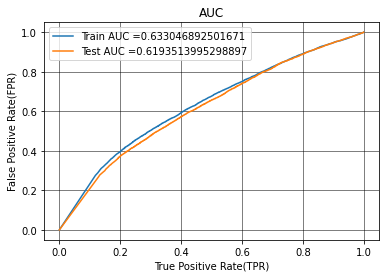

In [92]:
nb_tfidf = MultinomialNB(alpha = 1e-05,class_prior=[0.5,0.5])

nb_tfidf.fit(X_Train_final, y_train)

y_train_pred = batch_predict(nb_tfidf, X_Train_final)    
y_test_pred = batch_predict(nb_tfidf, X_Test_final)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [94]:
##Confusion matrix
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

[[ 3714  3712]
 [13458 28157]]


In [0]:
#20 important features

bow_features_names1 = []
for cnt in vectorizer_train.get_feature_names() :
    bow_features_names1.append(cnt)

for cnt2 in vectorizer_states.get_feature_names() :
    bow_features_names1.append(cnt2)

for cnt3 in vectorizer_project.get_feature_names() :
    bow_features_names1.append(cnt3)

for cnt4 in vectorizer_teacher.get_feature_names() :
    bow_features_names1.append(cnt4)

for cnt5 in vectorizer_bow_title.get_feature_names() :
    bow_features_names1.append(cnt5)

for cnt6 in vectorizer_bow_essay.get_feature_names() :
    bow_features_names1.append(cnt6)     



bow_features_names1.append("price")

bow_features_names1.append("quantity")


bow_features_names1.append("prev_proposed_projects")

bow_features_names1.append("title_word_count")

bow_features_names1.append("essay_word_count")

len(bow_features_names1)       

In [95]:
sorted_features = nb_tfidf.feature_log_prob_[1, :].argsort()[::-1]
for i in sorted_features[:20]:
    print(bow_features_names1[i])


ME
KS
HI
DC
NM
RI
DE
AK
Literacy
Mathematics
Literature_Writing
tight
amazed
tenor
SpecialNeeds
strenuous
AppliedSciences
NE
Health_Wellness
objective
